In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import math
import itertools
import torchvision.utils as vutils
from pytorch_fid import fid_score



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# parameters:

batch_size = 32  
source_data_path = './data'
img_size = 128
img_channels = 3
real_label = 1
fake_label = 0

# Net Params
latent_dim_values = [4, 8, 16, 32, 64, 128]
d_hidden_values = [64]
g_hidden_values = [64]

# Define the optimizers
lr_gen_values = [0.001, 0.0005, 0.0002]
beta1_gen_values = [0.5, 0.9]
beta2_gen_values = [0.999]
lr_dis_values = [0.001, 0.0005, 0.0002]
beta1_dis_values = [0.5, 0.9]
beta2_dis_values = [0.999]

num_epochs = 30





# Data preperation

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

dataset = ImageFolder(root=source_data_path, transform=data_transform)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)



In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
# # Generator Network
# class Generator(nn.Module):
#     def __init__(self, latent_dim, image_channels, img_size, g_hidden):
#         super(Generator, self).__init__()
#         self.main = nn.Sequential(
#             # input layer
#             nn.ConvTranspose2d(latent_dim, g_hidden * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(g_hidden * 8),
#             nn.ReLU(True),
#             # 1st hidden layer
#             nn.ConvTranspose2d(g_hidden * 8, g_hidden * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(g_hidden * 4),
#             nn.ReLU(True),
#             # 2nd hidden layer
#             nn.ConvTranspose2d(g_hidden * 4, g_hidden * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(g_hidden * 2),
#             nn.ReLU(True),
#             # 3rd hidden layer
#             nn.ConvTranspose2d(g_hidden * 2, g_hidden, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(g_hidden),
#             nn.ReLU(True),
#             # output layer
#             nn.ConvTranspose2d(g_hidden, img_channels, 4, 2, 1, bias=False),
#             nn.Tanh()
#         )

#     def forward(self, input):
#         return self.main(input)
# # Discriminator Network
# class Discriminator(nn.Module):
#     def __init__(self, image_channels, img_size, d_hidden):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             # 1st layer
#             nn.Conv2d(img_channels, d_hidden, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # 2nd layer
#             nn.Conv2d(d_hidden, d_hidden * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(d_hidden * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # 3rd layer
#             nn.Conv2d(d_hidden * 2, d_hidden * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(d_hidden * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # 4th layer
#             nn.Conv2d(d_hidden * 4, d_hidden * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(d_hidden * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # output layer
#             nn.Conv2d(d_hidden * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input).view(-1, 1).squeeze(1)

# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, img_size, g_hidden):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, img_channels * img_size * img_size),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, img_channels, img_size, d_hidden):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_channels * img_size * img_size, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.01),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [7]:
def train_gan(n_epochs, latent_dim, lr_gen, beta1_gen, beta2_gen, lr_dis, beta1_dis, beta2_dis, g_hidden, d_hidden, img_channels, img_size, data_loader, device):
    # Create GAN
    generator = Generator(latent_dim, img_channels, img_size, g_hidden)
    generator.apply(weights_init)
    discriminator = Discriminator(img_channels, img_size, d_hidden)
    discriminator.apply(weights_init)
    adversarial_loss = nn.BCELoss()

    # Move to GPU
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    adversarial_loss = adversarial_loss.to(device)

    # Create optimizers for the generator and discriminator
    generator_optimizer = optim.Adam(generator.parameters(), lr=lr_gen, betas=(beta1_gen, beta2_gen))
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr_dis, betas=(beta1_dis, beta2_dis))

    generator_losses = []
    discriminator_losses = []

    best_epoch = 0
    best_combined_loss = float('inf') 

    print_interval = 10


    for epoch in range(n_epochs):
        for batch_idx, (real_images, _) in enumerate(data_loader):
            real_images = real_images.to(device)

            # Training the discriminator
            discriminator_optimizer.zero_grad()

            z = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = generator(z).view(real_images.size())

            real_images_flat = real_images.view(real_images.size(0), -1)
            fake_images_flat = fake_images.view(fake_images.size(0), -1)

            real_labels = torch.ones(real_images.size(0), 1, device=device)
            fake_labels = torch.zeros(real_images.size(0), 1, device=device)
            real_loss = adversarial_loss(discriminator(real_images_flat), real_labels)
            fake_loss = adversarial_loss(discriminator(fake_images_flat.detach()), fake_labels)
            discriminator_loss = real_loss + fake_loss

            discriminator_loss.backward()
            discriminator_optimizer.step()

            # Training the generator
            generator_optimizer.zero_grad()

            # z = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = generator(z).view(real_images.size())

            fake_images_flat = fake_images.view(fake_images.size(0), -1)

            generator_loss = adversarial_loss(discriminator(fake_images_flat), real_labels)

            generator_loss.backward()
            generator_optimizer.step()

            discriminator_losses.append(discriminator_loss.item())
            generator_losses.append(generator_loss.item())

            if batch_idx % print_interval == 0:
                print(f"Epoch [{epoch}/{n_epochs}], Batch [{batch_idx}/{len(data_loader)}], "
                      f"Discriminator Loss: {discriminator_loss.item():.4f}, "
                      f"Generator Loss: {generator_loss.item():.4f}")

        # Calculate average losses for the epoch
        avg_generator_loss = np.mean(generator_losses)
        avg_discriminator_loss = np.mean(discriminator_losses)

        # Combine losses (e.g., sum or weighted sum)
        combined_loss = avg_generator_loss + avg_discriminator_loss

        # Check if this epoch has the best combined loss
        if combined_loss < best_combined_loss:
            best_combined_loss = combined_loss
            best_epoch = epoch
            # Save the weights if desired
            torch.save(generator.state_dict(), 'best_generator_weights.pth')
            torch.save(discriminator.state_dict(), 'best_discriminator_weights.pth')

        # Print epoch and losses for monitoring
        print(f"Epoch [{epoch}/{n_epochs}], Generator Loss: {avg_generator_loss:.4f}, "
            f"Discriminator Loss: {avg_discriminator_loss:.4f}, Combined Loss: {combined_loss:.4f}")

            # After training loop ends, print best epoch and best combined loss
    print(f"Best epoch: {best_epoch}, Best combined loss: {best_combined_loss:.4f}")
    return discriminator_losses, generator_losses, generator, discriminator


In [8]:
# Plot loss curves
def plot_train_losses(generator_losses, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.plot(generator_losses, label='Generator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Loss')
    plt.show()


In [9]:
def generate_n_image(num_images_to_generate, generator, latent_dim):
    generator.eval()
    # Generate random noise
    z = torch.randn(num_images_to_generate, latent_dim, device=device)
    # Generate images using the generator
    generated_images = generator(z).view(num_images_to_generate, img_channels, img_size, img_size)

    fig, axes = plt.subplots(1, num_images_to_generate, figsize=(15, 3))

    for i in range(num_images_to_generate):
        img_np = F.to_pil_image(generated_images[i].detach())
        axes[i].imshow(img_np)
        axes[i].axis('off')

    plt.show()

    generator.train()
#generate_n_image(5,generator, latent_dim_values[2])


In [ ]:
# hyper param res (in main_hyperparameters.ipynb)

# 2.3144018397519464 :  (4, 0.0002, 0.5, 0.999, 0.0002, 0.5, 0.999)
# 2.379516951661361 :  (8, 0.0002, 0.5, 0.999, 0.0002, 0.5, 0.999)
# 2.398989712094006 :  (16, 0.0002, 0.5, 0.999, 0.0002, 0.5, 0.999)
# 2.40447032247719 :  (8, 0.0005, 0.5, 0.999, 0.0002, 0.5, 0.999)
# 2.428759145736694 :  (4, 0.0005, 0.5, 0.999, 0.0002, 0.5, 0.999)
# 2.4922652091634903 :  (16, 0.0005, 0.5, 0.999, 0.0002, 0.5, 0.999)
# 2.4958378959643213 :  (32, 0.0002, 0.5, 0.999, 0.0002, 0.5, 0.999)
# 2.546199384174849 :  (4, 0.0005, 0.5, 0.999, 0.0005, 0.5, 0.999)
# 2.570624908020622 :  (8, 0.001, 0.5, 0.999, 0.0002, 0.5, 0.999)
# 2.5977609392059477 :  (32, 0.0005, 0.5, 0.999, 0.0002, 0.5, 0.999)

Epoch [0/30], Batch [0/38], Discriminator Loss: 1.3902, Generator Loss: 1.7909
Epoch [0/30], Batch [10/38], Discriminator Loss: 1.2275, Generator Loss: 2.0640
Epoch [0/30], Batch [20/38], Discriminator Loss: 1.1822, Generator Loss: 2.6541
Epoch [0/30], Batch [30/38], Discriminator Loss: 1.8895, Generator Loss: 2.2869
Epoch [0/30], Generator Loss: 2.0493, Discriminator Loss: 1.3488, Combined Loss: 3.3982
Epoch [1/30], Batch [0/38], Discriminator Loss: 0.7990, Generator Loss: 2.8287
Epoch [1/30], Batch [10/38], Discriminator Loss: 0.9782, Generator Loss: 2.0180
Epoch [1/30], Batch [20/38], Discriminator Loss: 0.9709, Generator Loss: 1.6841
Epoch [1/30], Batch [30/38], Discriminator Loss: 1.4657, Generator Loss: 2.7577
Epoch [1/30], Generator Loss: 1.9240, Discriminator Loss: 1.2075, Combined Loss: 3.1315
Epoch [2/30], Batch [0/38], Discriminator Loss: 0.9484, Generator Loss: 1.7874
Epoch [2/30], Batch [10/38], Discriminator Loss: 1.0596, Generator Loss: 1.5913
Epoch [2/30], Batch [20/38]

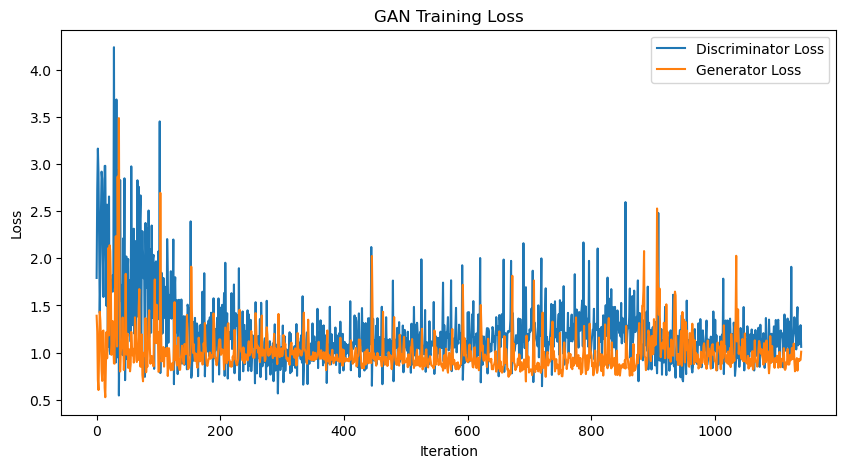

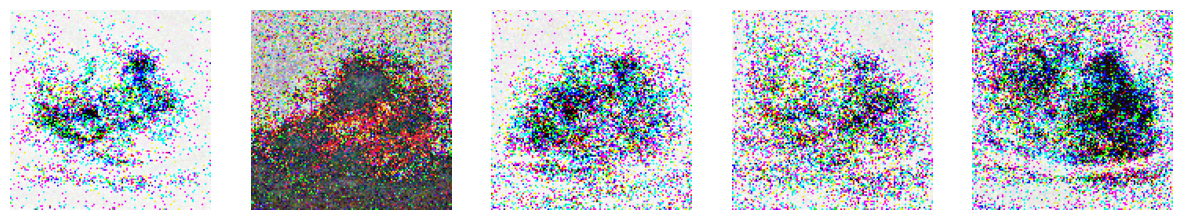

In [24]:
generator_losses, discriminator_losses, generator, discriminator = train_gan(
    30,
    4,
    0.0002,
    0.5,
    0.999,
    0.0002,
    0.5,
    0.999,
    g_hidden_values[0],
    d_hidden_values[0],
    img_channels,
    img_size,
    data_loader,
    device
)
plot_train_losses(generator_losses, discriminator_losses)
generate_n_image(5,generator, latent_dim_values[2])


In [19]:
# Assuming you've defined your models and their architectures
generator1 = Generator(latent_dim_values[2], img_channels, img_size, g_hidden_values[0])
discriminator1 = Discriminator(img_channels, img_size, d_hidden_values[0])

# Load the weights
generator1.load_state_dict(torch.load('best_generator_weights.pth'))
discriminator1.load_state_dict(torch.load('best_discriminator_weights.pth'))

generator1.to(device)
discriminator1.to(device)



Discriminator(
  (model): Sequential(
    (0): Linear(in_features=49152, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

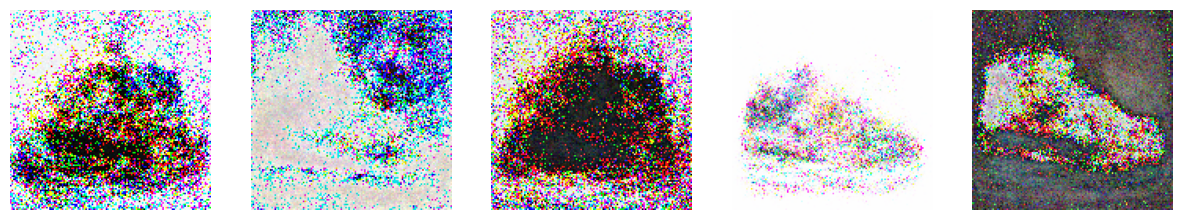

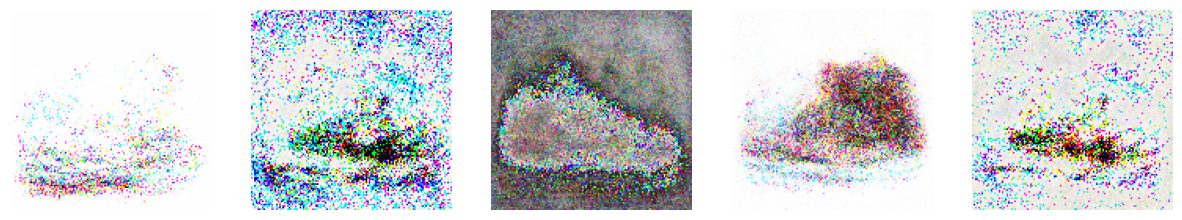

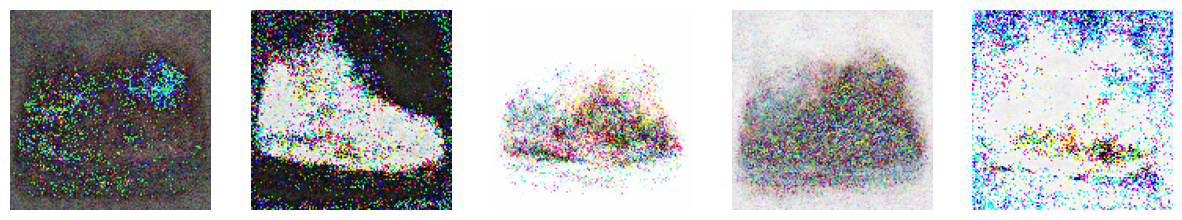

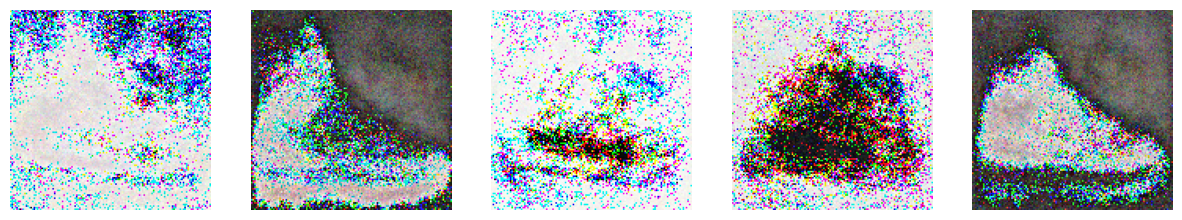

In [33]:
generate_n_image(5,generator1, latent_dim_values[2])
generate_n_image(5,generator1, latent_dim_values[2])
generate_n_image(5,generator1, latent_dim_values[2])
generate_n_image(5,generator1, latent_dim_values[2])